<a href="https://colab.research.google.com/github/Mithunjha/ITK_ImageRegistration3D/blob/main/Registration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import sys
!pip install itk
import itk 
from distutils.version import StrictVersion as VS
from ipywidgets import interactive, IntSlider
import matplotlib.pyplot as plt

In [3]:
if VS(itk.Version.GetITKVersion()) < VS("4.9.0"):
    print("ITK 4.9.0 is required.")
    sys.exit(1)

In [4]:
# if len(sys.argv) != 3:
#     print("Usage: " + sys.argv[0] + " <fixedImageFile> <movingImageFile>")
#     sys.exit(1)
# fixedImageFile = sys.argv[1]
# movingImageFile = sys.argv[2]
# outputImageFile = "." + movingImageFile.split('.')[1] + "_registered." + movingImageFile.split('.')[2]
# differenceImageAfterFile = "." + movingImageFile.split('.')[1] + "_difference_after." + movingImageFile.split('.')[2]
# differenceImageBeforeFile = "." + movingImageFile.split('.')[1] + "_difference_before." + movingImageFile.split('.')[2]

base = "/content/drive/MyDrive/Registration/"
fixedImageFile = base + "VF-MRT1-1014-1174.vtk"
movingImageFile = base + "VF-MRT2-1014-1174.vtk"
outputImageFile = base + "registered.vtk"
differenceImageAfterFile = base +  "difference_after.vtk"
differenceImageBeforeFile = base + "difference_before.vtk"

In [45]:
fixed_vis = itk.imread(fixedImageFile)
moving_vis = itk.imread(movingImageFile)

print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=fixed_vis.shape[0]-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices
# set true for continuous_update

# Define a function for plotting images
def plot_slices(sliced):
    fig, ax = plt.subplots(1,2, figsize=(10,5))
    ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title(f'Fixed Images : Slice {sliced}',fontsize = 20)
    ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title(f'Moving Images : Slice {sliced}',fontsize = 20)


# Use the interactive() tool to create the visualization
interactive(plot_slices , sliced=select_slice)

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=32), Output())…

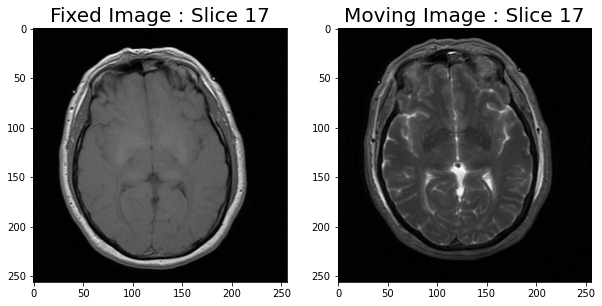

In [43]:
sliced = 17
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title(f'Fixed Image : Slice {sliced}',fontsize = 20);
ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title(f'Moving Image : Slice {sliced}',fontsize = 20);

In [6]:
PixelType = itk.F

fixedImage = itk.imread(fixedImageFile, PixelType)
movingImage = itk.imread(movingImageFile, PixelType)

Dimension = fixedImage.GetImageDimension()

FixedImageType = itk.Image[PixelType, Dimension]
MovingImageType = itk.Image[PixelType, Dimension]

TransformType = itk.TranslationTransform[itk.D, Dimension]
initialTransform = TransformType.New()

print(f"Shape of fixed image : {fixedImage.shape}")
print(f"Dimension : {Dimension}")
print(f"ITKImageType of fixed image : {FixedImageType}")
print(f"ITKImageType of moving image : {MovingImageType}")

Shape of fixed image : (33, 256, 256)
Dimension : 3
ITKImageType of fixed image : <class 'itk.itkImagePython.itkImageF3'>
ITKImageType of moving image : <class 'itk.itkImagePython.itkImageF3'>


In [35]:
optimizer = itk.RegularStepGradientDescentOptimizerv4.New(LearningRate=0.5,MinimumStepLength=0.001,RelaxationFactor=0.5,NumberOfIterations=100)
metric = itk.MeanSquaresImageToImageMetricv4[FixedImageType, MovingImageType].New()

registration = itk.ImageRegistrationMethodv4[FixedImageType,MovingImageType].New(FixedImage=fixedImage,
                                                                                 MovingImage=movingImage,
                                                                                 Metric=metric,
                                                                                 Optimizer=optimizer,
                                                                                 InitialTransform=initialTransform)

In [36]:
movingInitialTransform = TransformType.New()
initialParameters = movingInitialTransform.GetParameters()
initialParameters[0] = 0
initialParameters[1] = 0
movingInitialTransform.SetParameters(initialParameters)
registration.SetMovingInitialTransform(movingInitialTransform)

identityTransform = TransformType.New()
identityTransform.SetIdentity()
registration.SetFixedInitialTransform(identityTransform)

In [37]:

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])


registration.Update()

transform = registration.GetTransform()
finalParameters = transform.GetParameters()
translationAlongX = finalParameters.GetElement(0)
translationAlongY = finalParameters.GetElement(1)

numberOfIterations = optimizer.GetCurrentIteration()

bestValue = optimizer.GetValue()

print("Result = ")
print(" Translation X = " + str(translationAlongX))
print(" Translation Y = " + str(translationAlongY))
print(" Iterations    = " + str(numberOfIterations))
print(" Metric value  = " + str(bestValue))





Result = 
 Translation X = -0.11893706932479385
 Translation Y = -9.55165054010077
 Iterations    = 14
 Metric value  = 9196.548948132186


In [21]:
CompositeTransformType = itk.CompositeTransform[itk.D, Dimension]
outputCompositeTransform = CompositeTransformType.New()
outputCompositeTransform.AddTransform(movingInitialTransform)
outputCompositeTransform.AddTransform(registration.GetModifiableTransform())


resampler = itk.ResampleImageFilter.New(Input=movingImage,
        Transform=outputCompositeTransform,
        UseReferenceImage=True,
        ReferenceImage=fixedImage)

resampler.SetDefaultPixelValue(100)#############


# OutputPixelType = itk.ctype('unsigned char')
# OutputImageType = itk.Image[OutputPixelType, Dimension]

# caster = itk.CastImageFilter[FixedImageType,
#         OutputImageType].New(Input=resampler)

# out_vis = caster.GetOutput()

OutputPixelType = itk.F
OutputImageType = itk.Image[OutputPixelType, Dimension]

out_vis = resampler.GetOutput()

writer = itk.ImageFileWriter.New(Input=resampler, FileName=outputImageFile)
writer.SetFileName(outputImageFile)
writer.Update()

In [24]:
difference = itk.SubtractImageFilter.New(Input1=fixedImage,
        Input2=resampler)

intensityRescaler = itk.RescaleIntensityImageFilter[FixedImageType,OutputImageType].New(
            Input=difference,
            OutputMinimum=itk.NumericTraits[OutputPixelType].min(),
            OutputMaximum=itk.NumericTraits[OutputPixelType].max())

after_vis = intensityRescaler.GetOutput()
resampler.SetDefaultPixelValue(1)
writer.SetInput(intensityRescaler.GetOutput())
writer.SetFileName(differenceImageAfterFile)
writer.Update()


resampler.SetTransform(identityTransform)
before_vis = intensityRescaler.GetOutput()
writer.SetFileName(differenceImageBeforeFile)
writer.Update()

In [25]:
print("Choose the slice using slice selection slider")
select_slice = IntSlider(min=0, max=fixed_vis.shape[0]-1, description='Slice No: ', continuous_update=False) # slider from 0 to max number of slices # set true for continuous_update

# Define a function for plotting images
def plot_slices(sliced):
    fig, ax = plt.subplots(1,5, figsize=(50,25))
    ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title('Fixed Images',fontsize = 30)
    ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title('Moving Images',fontsize = 30)
    ax[2].imshow(out_vis[sliced], cmap='gray'), ax[2].set_title('Output Images',fontsize = 30)
    ax[3].imshow(before_vis[sliced], cmap='gray'), ax[3].set_title('Difference Before Registration Images',fontsize = 30)
    ax[4].imshow(after_vis[sliced], cmap='gray'), ax[4].set_title('Difference After Images',fontsize = 30)


# Use the interactive() tool to create the visualization
interactive(plot_slices , sliced=select_slice)

Choose the slice using slice selection slider


interactive(children=(IntSlider(value=0, continuous_update=False, description='Slice No: ', max=32), Output())…

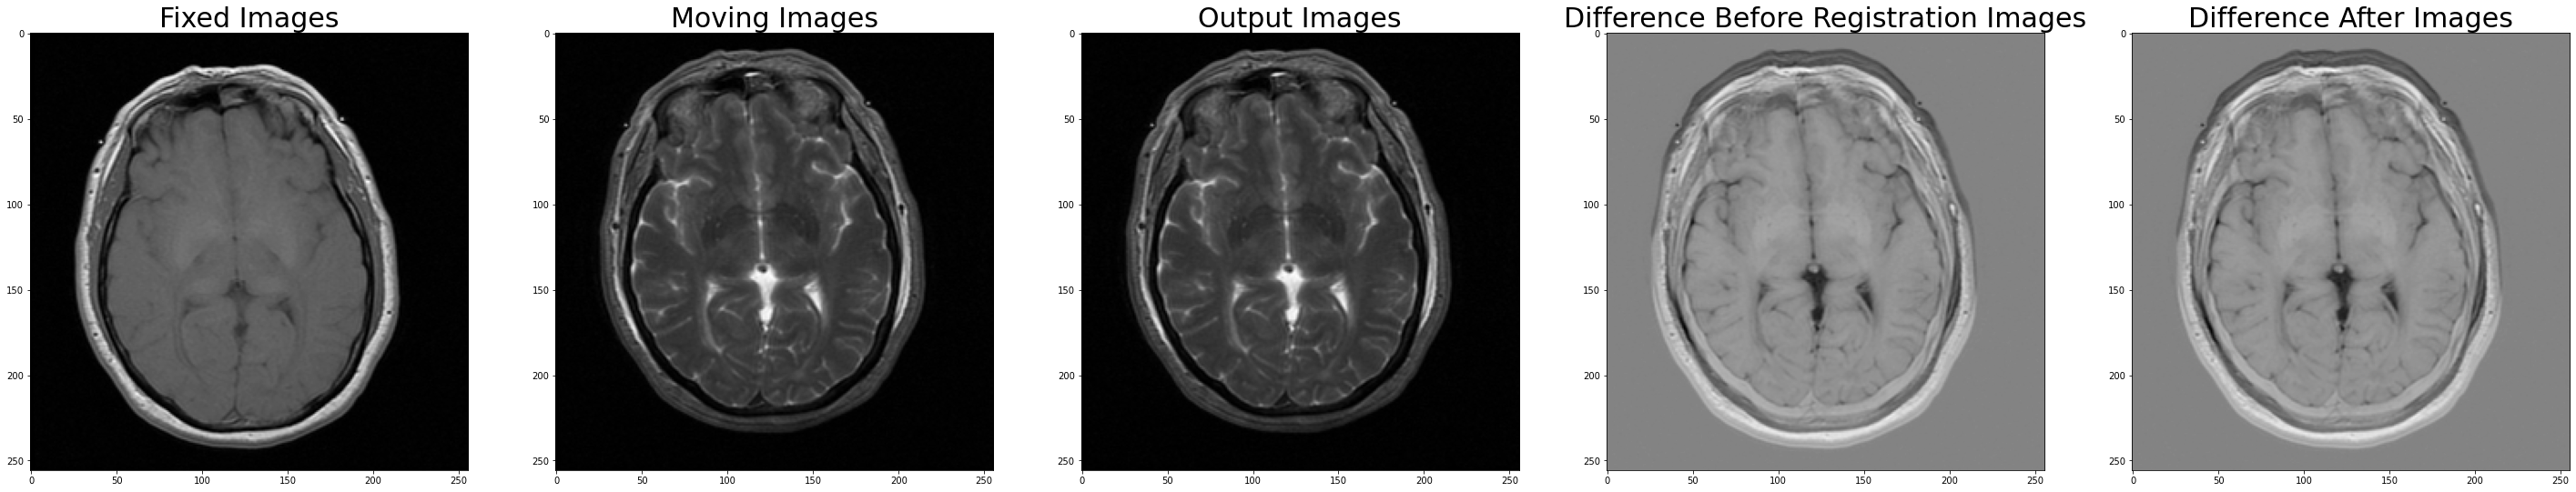

In [39]:
sliced = 17
fig, ax = plt.subplots(1,5, figsize=(50,25))
ax[0].imshow(fixed_vis[sliced], cmap='gray'), ax[0].set_title('Fixed Images',fontsize = 30)
ax[1].imshow(moving_vis[sliced], cmap='gray'), ax[1].set_title('Moving Images',fontsize = 30)
ax[2].imshow(out_vis[sliced], cmap='gray'), ax[2].set_title('Output Images',fontsize = 30);
ax[4].imshow(after_vis[sliced], cmap='gray'), ax[4].set_title('Difference After Images',fontsize = 30);
ax[3].imshow(before_vis[sliced], cmap='gray'), ax[3].set_title('Difference Before Registration Images',fontsize = 30);